# Stock Clustering - Do they provide diversification benefits?

<a id='1.1'></a>
## 2.1. Loading the python packages

In [45]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas_datareader as dr
import pickle

# Import Model Packages 
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from statsmodels.tsa.stattools import coint

# Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle

import yahoo_fin.stock_info as si
import yfinance as yf

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2022-10-16 13:39:37 +08:00)


<a id='1.2'></a>
## 2.2. Loading the Data

In [46]:
# The dataset was obtained from Kaggle and imported
dataset = pickle.load(open('./data/01_pricedate_2015_2019.pkl', 'rb'))

time: 15 ms (started: 2022-10-16 13:39:37 +08:00)


In [47]:
# Shape of dataset
dataset.shape

(1256, 487)

time: 0 ns (started: 2022-10-16 13:39:38 +08:00)


In [48]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,37.420,51.051,151.337,24.120,46.711,79.662,37.07,39.125,76.427,71.98,...,127.431,29.178,64.219,49.260,32.530,44.445,107.126,76.34,24.042,41.036
2015-01-06,36.837,50.256,151.230,24.122,46.480,80.097,36.13,38.681,75.875,70.53,...,124.712,29.334,63.878,48.649,32.339,43.900,106.218,75.79,23.124,40.636
2015-01-07,37.326,50.227,154.480,24.461,48.358,81.696,37.28,38.994,77.468,71.11,...,128.375,29.587,64.525,49.909,32.594,45.354,108.859,77.72,23.345,41.474
2015-01-08,38.445,50.843,155.834,25.400,48.864,81.882,38.96,39.796,78.649,72.92,...,129.919,29.930,65.599,51.142,32.840,46.144,110.015,79.38,23.671,42.113
2015-01-09,38.163,49.289,155.041,25.428,47.527,82.602,38.41,39.378,78.562,71.84,...,131.543,29.562,65.507,50.397,32.220,46.063,108.428,80.54,23.009,42.180


time: 16 ms (started: 2022-10-16 13:39:39 +08:00)


In [49]:
# describe data
set_option('precision', 3)
dataset.describe()

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
count,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,...,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000
mean,55.006,39.638,143.622,36.906,59.805,82.091,182.990,52.047,127.330,167.241,...,111.760,40.805,62.954,53.025,54.490,70.015,109.944,122.043,36.427,68.409
std,14.512,7.182,23.422,11.335,14.624,8.115,107.157,15.550,33.608,79.427,...,30.902,9.438,3.668,7.393,16.691,18.610,11.452,53.268,9.894,25.690
min,31.622,24.281,77.127,21.099,36.022,62.801,36.130,32.535,73.530,69.990,...,46.518,26.588,50.110,33.568,27.965,42.096,84.815,46.930,17.704,37.846
25%,39.922,33.877,136.224,26.777,47.497,76.607,97.265,39.348,100.986,93.993,...,89.535,34.143,60.485,49.051,38.141,55.215,103.562,80.683,25.753,46.105
50%,57.711,39.597,149.835,36.048,56.181,81.444,142.980,45.068,117.823,143.605,...,111.691,39.919,63.094,54.760,51.807,68.095,109.340,105.910,38.932,60.530
75%,66.881,45.370,158.723,45.070,73.447,85.989,265.538,64.727,152.798,249.120,...,131.382,45.372,65.577,58.498,71.192,82.795,116.975,163.580,45.054,86.562
max,84.129,56.989,194.023,72.026,99.695,102.871,449.750,85.388,205.783,331.200,...,190.356,62.595,71.204,66.581,82.366,114.009,144.435,258.280,53.566,131.554


time: 453 ms (started: 2022-10-16 13:39:40 +08:00)


<a id='5.4'></a>
## 5.4. Cluster Evaluation

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

In [25]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("hc", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.3720889901158577
hc 0.2793083053135605
ap 0.32830087184322787
time: 31 ms (started: 2022-10-16 10:34:27 +08:00)


Given the affinity propagation performs the best, we go ahead with the affinity propagation and use 27 clusters as specified by this clustering method

### Visualising the return within a cluster

The understand the intuition behind clustering, let us visualize the results of the clusters.

In [26]:
# all stock with its cluster label (including -1)
clustered_series = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
clustered_series = clustered_series[clustered_series != -1]

time: 875 ms (started: 2022-10-16 10:34:27 +08:00)


In [27]:
# get the number of stocks in each cluster
counts = clustered_series_ap.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<25) & (counts>1)].index)[::-1]
cluster_vis_list

[9, 17, 19, 5, 1, 16, 20, 11, 3, 8, 13, 2, 29, 32, 25, 18, 15, 4, 12, 31, 14]

time: 0 ns (started: 2022-10-16 10:34:28 +08:00)


In [28]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 29
Pairs to evaluate: 11098
time: 0 ns (started: 2022-10-16 10:34:28 +08:00)


In [29]:
# plot a handful of the smallest clusters
plt.figure(figsize=(12,7))
cluster_vis_list[0:min(len(cluster_vis_list), 4)]

[9, 17, 19, 5]

<Figure size 864x504 with 0 Axes>

time: 15 ms (started: 2022-10-16 10:34:28 +08:00)


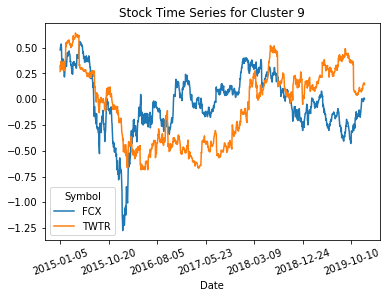

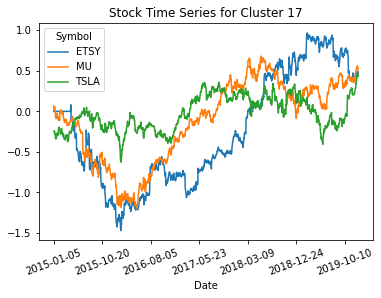

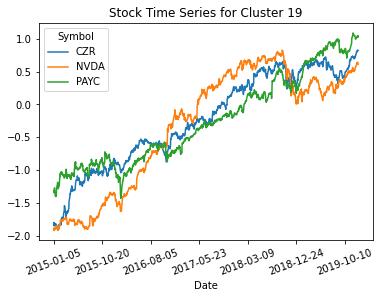

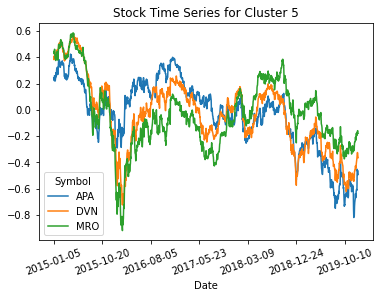

time: 422 ms (started: 2022-10-16 11:10:12 +08:00)


In [44]:
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(dataset.loc[:"2019-12-31", tickers].mean())
    data = np.log(dataset.loc[:"2019-12-31", tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)
    plt.xticks(rotation=20)
plt.show()

Looking at the charts above, across all the clusters with small number of stocks, we
see similar movement of the stocks under different clusters, which corroborates the
effectiveness of the clustering technique.

<a id='6'></a>
# 6. Pairs Selection

<a id='6.1'></a>
## 6.1. Cointegration and Pair Selection Function

We set the significance at 0.05, so if p-value is less than 0.05, we reject the null hypothesis that there is no cointegration. 

In [31]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

time: 0 ns (started: 2022-10-16 10:34:29 +08:00)


In [32]:

cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index   
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        dataset[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

time: 10.7 s (started: 2022-10-16 10:34:29 +08:00)


In [33]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

time: 0 ns (started: 2022-10-16 10:34:39 +08:00)


In [34]:
print ("Number of pairs found : %d" % len(pairs))
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)))

Number of pairs found : 47
In those pairs, there are 62 unique tickers.
time: 16 ms (started: 2022-10-16 10:34:39 +08:00)


In [35]:
pairs

[('A', 'WAT'),
 ('AXP', 'ORCL'),
 ('ADI', 'CRL'),
 ('ADI', 'DE'),
 ('ADI', 'DRI'),
 ('ADI', 'GRMN'),
 ('ADI', 'LYV'),
 ('ADI', 'ODFL'),
 ('ABT', 'FDS'),
 ('AEE', 'AFL'),
 ('AEE', 'CCI'),
 ('AEE', 'CPT'),
 ('AEE', 'DTE'),
 ('AEE', 'MMC'),
 ('AEE', 'PAYX'),
 ('AEE', 'UDR'),
 ('AVB', 'D'),
 ('AVB', 'ETR'),
 ('AVB', 'KO'),
 ('AVB', 'PEP'),
 ('AVB', 'PG'),
 ('AVB', 'SO'),
 ('AVB', 'SRE'),
 ('ACN', 'FIS'),
 ('ACN', 'NDAQ'),
 ('ACN', 'SYK'),
 ('ACN', 'TMO'),
 ('ABBV', 'CAT'),
 ('ABBV', 'LVS'),
 ('ABBV', 'LYB'),
 ('ABBV', 'RF'),
 ('ABBV', 'SCHW'),
 ('ANSS', 'CTAS'),
 ('ANSS', 'EL'),
 ('ANSS', 'LHX'),
 ('ANSS', 'SPGI'),
 ('ANSS', 'TDY'),
 ('ANSS', 'ZTS'),
 ('ABC', 'GILD'),
 ('ABC', 'NWSA'),
 ('AJG', 'HD'),
 ('AJG', 'NEE'),
 ('AIG', 'SPG'),
 ('DXC', 'FANG'),
 ('ADSK', 'AVGO'),
 ('ADSK', 'MPWR'),
 ('AAP', 'WBD')]

time: 0 ns (started: 2022-10-16 10:34:39 +08:00)


<a id='6.2'></a>
## 6.2. Pair Visualization

In [36]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=X.index, data=X).T

time: 0 ns (started: 2022-10-16 10:34:39 +08:00)


In [37]:
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.T.loc[stocks]

time: 0 ns (started: 2022-10-16 10:34:39 +08:00)


In [38]:
X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

time: 203 ms (started: 2022-10-16 10:34:39 +08:00)


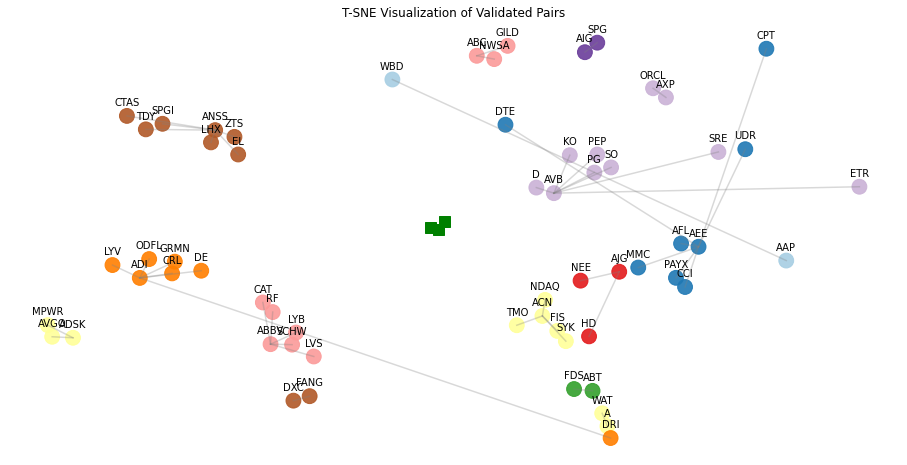

time: 296 ms (started: 2022-10-16 10:34:40 +08:00)


In [39]:
plt.figure(1, facecolor='white',figsize=(16,8))
plt.clf()
plt.axis('off')
for pair in pairs:
    #print(pair[0])
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    #print(ticker1, loc1)

    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs'); 

# zip joins x and y coordinates in pairs
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)


**Conclusion**

The clustering techniques do not directly help in stock trend prediction. However,
they can be effectively used in portfolio construction for finding the right pairs,
which eventually help in risk mitigation and one can achieve superior risk adjusted
returns.

We showed the approaches to finding the appropriate number of clusters in k-means
and built a hierarchy graph in hierarchical clustering. A next step from this case study
would be to explore and backtest various long/short trading strategies with pairs of
stocks from the groupings of stocks.

Clustering can effectively be used for dividing stocks into groups with “similar characteristics” for many other kinds of trading strategies and can help in portfolio construction to ensure we choose a universe of stocks with sufficient diversification
between them.